### Importação das bibliotecas

In [1]:
import numpy as np
import pickle as pkl
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPool2D
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2025-02-25 07:41:48.553286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740480108.581306  162188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740480108.588559  162188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 07:41:48.616174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version: 2.18.0
GPU is NOT AVAILABLE


2025-02-25 07:41:54.074203: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-25 07:41:54.074241: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: Debian
2025-02-25 07:41:54.074250: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: Debian
2025-02-25 07:41:54.074438: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.216.1
2025-02-25 07:41:54.074470: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.216.1
2025-02-25 07:41:54.074476: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.216.1


### Listagem de arquivos em diretório com contagem total

In [4]:
filenames = [os.path.join('images', file) for file in os.listdir('images')]
len(filenames)

44441

### Carrega o modelo pré-treinado (ResNet50 sem a camada superior)

In [5]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model = tf.keras.models.Sequential([model, GlobalMaxPool2D()])
model.summary()

I0000 00:00:1740434050.114425   65573 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2746 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Processamento de imagem e geração de embeddings normalizados para classificação

In [7]:
img = image.load_img('1163.jpg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_expand_dim = np.expand_dims(img_array, axis=0)
img_preprocess = preprocess_input(img_expand_dim)
result = model.predict(img_preprocess).flatten()
norm_result = result/norm(result)
norm_result

I0000 00:00:1740435894.698240   68367 service.cc:148] XLA service 0x7f817c003760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740435894.698259   68367 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-02-24 19:24:54.806398: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740435895.387914   68367 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-24 19:24:56.227574: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[1,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1740435897.916888   68367 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([0.00491866, 0.05812975, 0.00543876, ..., 0.00351524, 0.05245372,
       0.03639519], dtype=float32)

### Função para extração e normalização de características de imagem com ResNet50

In [10]:
def extract_features_from_images(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)
    result = model.predict(img_preprocess).flatten()
    norm_result = result/norm(result)
    return norm_result

In [11]:
extract_features_from_images(filenames[0], model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([0.        , 0.        , 0.01036665, ..., 0.01024433, 0.01551058,
       0.00107723], dtype=float32)

### Extração de características de todas as imagens do dataset

In [31]:
image_features = []
for file in filenames:
    image_features.append(extract_features_from_images(file, model))

: 

### Serialização e desserialização de características extraídas com Pickle

#### Salvando os dados com pickle

In [13]:
Image_features = pkl.dump(image_features, open('Images_features.pkl', 'wb'))
filenames = pkl.dump(filenames, open('filenames.pkl', 'wb'))

#### Carregando os dados salvos

In [19]:
Image_features = pkl.load(open('Images_features.pkl', 'rb'))
filenames = pkl.load(open('filenames.pkl', 'rb'))

#### Verificando a forma da matriz de características

In [22]:
np.array(Image_features).shape

(10, 2048)

### Implementação de busca por imagens similares com nearest neighbors

In [23]:
neighbors = NearestNeighbors(n_neighbors= 6, algorithm='brute', metric= 'euclidean')

### Indexação das características com nearest neighbors para busca de imagens

In [24]:
neighbors.fit(Image_features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

### Extração de características da imagem de entrada para busca similar

In [25]:
input_image = extract_features_from_images('1163.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


### Busca por imagens similares usando nearest neighbors

In [26]:
distance, indices = neighbors.kneighbors([input_image])
indices[0]

array([8, 3, 0, 6, 1, 9])

In [27]:
similar_images = [filenames[i] for i in indices[0]]
print(similar_images)

['images/38127.jpg', 'images/37210.jpg', 'images/4575.jpg', 'images/44841.jpg', 'images/36754.jpg', 'images/22162.jpg']


### Exibição das imagens similares ao resultado da busca

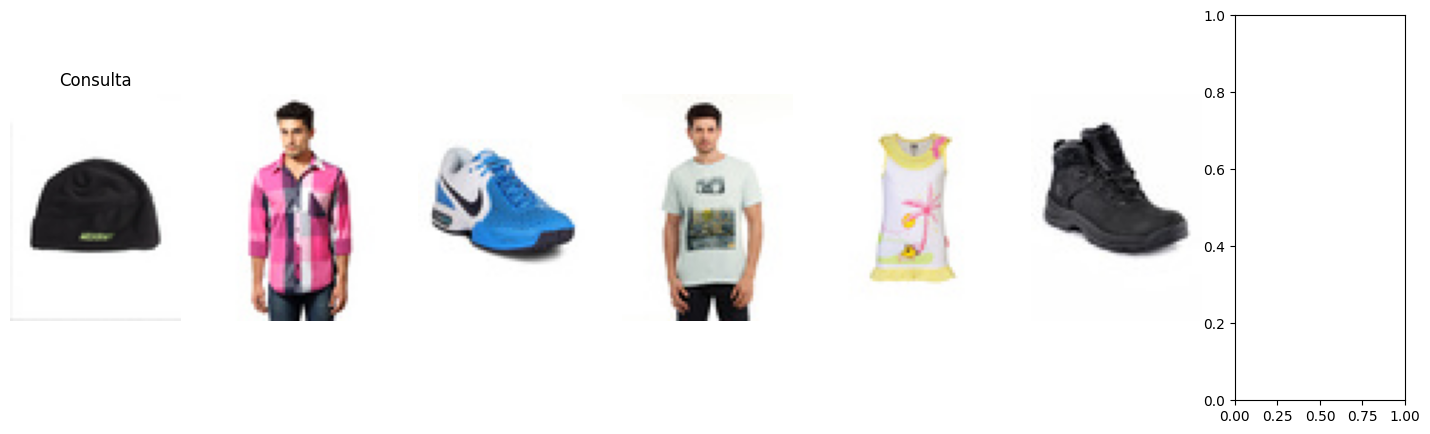

In [29]:
fig, axes = plt.subplots(1,7, figsize=(18, 5))

query_img = cv2.imread('1163.jpg')[:, :, ::-1]
axes[0].imshow(query_img)
axes[0].axis('off')
axes[0].set_title("Consulta", fontsize=12)

for ax, img_path in zip(axes, similar_images):
    img = cv2.imread(img_path)[:, :, ::-1]
    ax.imshow(img)
    ax.axis('off')

plt.show()